In [1]:
#Importing all the libraries needed
import keras
import h5py
from keras import optimizers, preprocessing, Input
from keras.models import load_model, Model
from keras.layers import Bidirectional
#from multimodel baseline functions
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import  plot_model
import os
import itertools
#import keras matrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications.inception_v3 import InceptionV3

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
# from nltk import word_tokenize
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D, Embedding, LSTM, multiply
from PIL import Image, ImageFile

In [2]:
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile('^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
#training_path, testing_path and validation_path are for the text extracted from the meme images respectively in a .csv file
Training_path = '/content/drive/MyDrive/Code and Program/MultiOFF_Dataset/Split Dataset/Training_meme_dataset.csv'
Testing_path = '/content/drive/MyDrive/Code and Program/MultiOFF_Dataset/Split Dataset/Testing_meme_dataset.csv'
Validation_path = '/content/drive/MyDrive/Code and Program/MultiOFF_Dataset/Split Dataset/Validation_meme_dataset.csv'
img_dir = '/content/drive/MyDrive/Code and Program/MultiOFF_Dataset/Labelled Images'

In [5]:
maxlen = 1000

In [6]:
#directory for storing glove embeddings
GLOVE_DIR = "/content/drive/MyDrive/Code and Program/"
EMBEDDING_DIM = 50

In [7]:
#assigning weight
class_weight = {1: 1.4,
                0: 1}

In [8]:
#model with adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=None, decay=0.0)

In [9]:
def Image_model(base_model):
  #freezing all the trainable layers
  for layer in base_model.layers:
    layer.trainable = False
  #create output layer
  x = base_model.output
  #pooling layer before the output
  x = GlobalAveragePooling2D()(x)
  return x

In [10]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [11]:
def encode_label(DataFrame, Label_col):
    t_y = DataFrame[Label_col].values
    Encoder = LabelEncoder()
    y = Encoder.fit_transform(t_y)
    DataFrame[Label_col] = y

In [12]:
def clean_text(text):
   text = text.lower()
   text = EMAIL.sub('', text)
#     text = NUMBERS.sub('',text)
   text = REPLACE_BY_SPACE_RE.sub(' ',text)
   text = BAD_SYMBOLS.sub('',text)    
   text = text.replace('x','')
   text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
   return text

In [13]:
def preprocess_text(Training_path,Validation_path, Testing_path):
    # function to preprocess input
    training_DF = pd.read_csv(Training_path, sep = ',')
    validation_DF = pd.read_csv(Validation_path, sep = ',')
    testing_DF = pd.read_csv(Testing_path, sep = ',')

    # encoding all the labels 
    encode_label(testing_DF,'label')
    encode_label(training_DF, 'label')
    encode_label(validation_DF, 'label')

    clean_text(training_DF['sentence'][0])

    # Processing the text
    training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
    testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
    validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

    return training_DF, testing_DF, validation_DF

In [16]:
#splitting data into train, test and validation
training_df, testing_df, validation_df = preprocess_text(Training_path,Validation_path, Testing_path)

In [17]:
def create_img_array(img_dirct):
    all_imgs = []
    for root, j, files in os.walk(img_dirct):
        for file in files:
            file = root + '/' + file
            all_imgs.append(file)
    return all_imgs

def create_img_path(DF, Col_name, img_dir):
    img_path = [img_dir + '/' + name for name in DF[Col_name]]
    return img_path

In [18]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_df,'image_name', img_dir)
test_img_path = create_img_path(testing_df,'image_name', img_dir)
val_img_path = create_img_path(validation_df,'image_name', img_dir)

# Processing the text
training_df['sentence'] = training_df['sentence'].apply(clean_text)
testing_df['sentence'] = testing_df['sentence'].apply(clean_text)
validation_df['sentence'] = validation_df['sentence'].apply(clean_text)

In [19]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_df['sentence'])
test_text_list = list(testing_df['sentence'])
val_text_list = list(validation_df['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_df['label']
y_train = training_df['label']
y_val = validation_df['label']

In [20]:
def img_text_generator(files, padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    while True:
        batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input_txt = [] # Initializing batch input text
        batch_input_img = [] # Initializing batch input image
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input_txt = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label  
            input_img = get_input(files[batch_idx])
            input_img = process_input(input_img)
            batch_input_txt.append(input_txt) # Appending the input (text vector)
            batch_input_img.append(input_img[0])
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x1 = np.array( batch_input_img )
        batch_x2 = np.array( batch_input_txt )
        batch_y = np.array( batch_output )
        yield ([batch_x1, batch_x2], batch_y)

In [21]:
def text_generator(padded_seq, y, batch_size=None):
    """
        padded_seq: vectorized padded text sequence 
        y: label of the text
        batch_size: Number of observations to be selected at a time
        
        return: generator object of text data
    """
    idxs = list(range(len(y)))
    idx = 0
    while True:
        batch_idxs = idxs[idx:idx+batch_size]
        idx = idx + batch_size
#         batch_idxs = np.random.choice(a = list(range(len(padded_seq))), size=batch_size) #Selecting the random batch indexes    
        batch_input = [] # Initializing batch input
        batch_output = [] # Initializing batch output
        
        # Traversing through the batch indexes
        for batch_idx in batch_idxs:
            input = padded_seq[batch_idx] # selecting padded sequences from the batch
            output = y[batch_idx] # Selecting label            
            batch_input.append(input) # Appending the input (text vector)
            batch_output.append(output) # Appending the label
        
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [22]:
def get_input(path):
    # Loading image from given path
    # and resizing it to 224*224*3 format
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    img = image.load_img(path, target_size=(224,224))    
    return(img)

In [23]:
def get_output(path,label_file=None):
    # Spliting the path and take out the image id    
    filename = path.split('/')[-1]
    # Taking list of labels
    labels = list(label_file[label_file['image_name'] == filename]['label'].values)
    # for duplicate selecting labels
    if len(labels) <= 2:
        label = labels[0]
    elif len(labels) > 2:
        uni_label = list(set(labels))
        count_label = [labels.count(lab) for lab in uni_label]
        lab_idx = count_label.index(max(count_label))
        label = uni_label[lab_idx]
    return label

In [24]:
def process_input(img):
    # Converting image to array    
    img_data = image.img_to_array(img)
    # Adding one more dimension to array    
    img_data = np.expand_dims(img_data, axis=0)
    #     
    img_data = preprocess_input(img_data)
    return(img_data)

In [25]:
# Function to generate the data
def image_generator(files,label_file, batch_size = None):   
    """
        files: list of image paths 
        label_file: labels of the observations
        batch_size: Number of observations to be selected at a time
        
        return: generator object of image data
    """
    idxs = list(range(len(files)))
    idx = 0
    while True: 
        batch_paths = files[idx:idx+batch_size]
#         batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = [] # Batch input initialization
        batch_output = [] # Batch output initialization
          
        # Read in each input, perform preprocessing and get labels    
        for input_path in batch_paths:
            input = get_input(input_path) # Load image
            output = get_output(input_path,label_file=label_file) # Load label of the image
            input = process_input(img=input) # Process the image
            batch_input.append(input[0]) # Append the image
            batch_output.append(output)  # Append the label
            
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        if len(batch_x) < batch_size:
            idx = 0
        else:             
            yield (batch_x, batch_y)

In [26]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_df, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_df, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_df, batch_size=1)

In [27]:
# Creating vocabulary with glove embeddings
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [28]:
#creating word index
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [29]:
#embedding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word,i in word_index.items():
  embedding_vector = w2v.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [30]:
#embedding layer using embedding matrix as the weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)

In [31]:
#defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

In [32]:
#embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)

#LSTM will convert the sequence of vectors to single vector containing the information about the entire sequence
lstm1 = LSTM(32, return_state=True)
encoder_outputs,state_h,state_c = (lstm1)(embedded_sequences)
states = [state_h, state_c]

In [33]:
#second LSTM
lstm2 = LSTM(32, return_sequences=True, return_state=True)
#adding initial state as state of previous LSTM
decoder_out,_,_ = lstm2(embedded_sequences, initial_state=states)
#Dense layer with 500 neurons
decoder_dense = (Dense(500, activation='relu'))

lstm_out = (decoder_out)

lstm_out = Flatten()(lstm_out)
#output of the text model
txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [34]:
#defining text model
txt_model = Model(inputs = [main_input], outputs=txt_out)

In [35]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

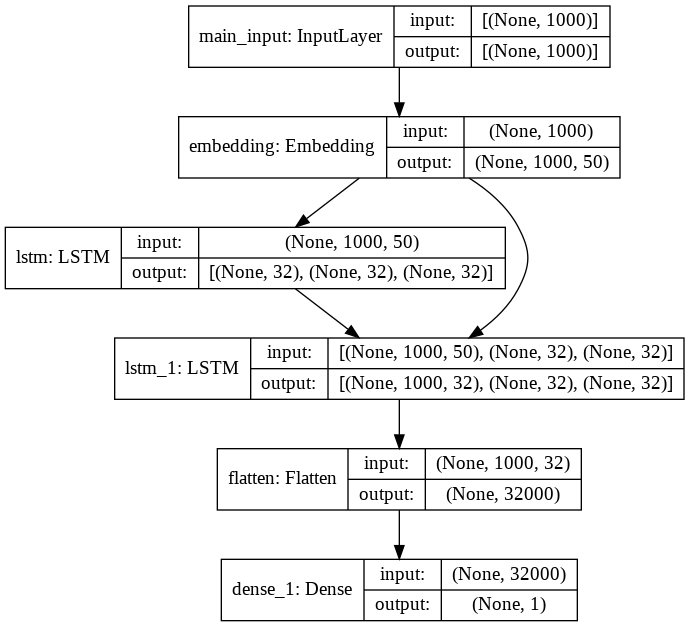

In [36]:
plot_model(txt_model, to_file='/content/drive/MyDrive/Code and Program/Stack_LSTM_txt.png', show_shapes=True, show_layer_names=True)

In [37]:
#Training text model
model1 = txt_model.fit_generator(txt_gen_train, epochs=7, validation_steps=149, steps_per_epoch=2, validation_data=txt_gen_val, shuffle=False, class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
2/2 [==============================] - 12s 8s/step - loss: 0.8181 - accuracy: 0.5417 - val_loss: 0.7061 - val_accuracy: 0.4161
Epoch 2/7
2/2 [==============================] - 8s 8s/step - loss: 0.8026 - accuracy: 0.3750 - val_loss: 0.6874 - val_accuracy: 0.5705
Epoch 3/7
2/2 [==============================] - 9s 8s/step - loss: 0.7667 - accuracy: 0.6562 - val_loss: 0.6695 - val_accuracy: 0.6107
Epoch 4/7
2/2 [==============================] - 8s 8s/step - loss: 0.8691 - accuracy: 0.5417 - val_loss: 0.6714 - val_accuracy: 0.6107
Epoch 5/7
2/2 [==============================] - 8s 8s/step - loss: 0.8222 - accuracy: 0.5729 - val_loss: 0.6808 - val_accuracy: 0.6040
Epoch 6/7
2/2 [==============================] - 8s 8s/step - loss: 0.7993 - accuracy: 0.5833 - val_loss: 0.6911 - val_accuracy: 0.5638
Epoch 7/7
2/2 [==============================] - 8s 8s/step - loss: 0.8229 - accuracy: 0.5938 - val_loss: 0.7045 - val_accuracy: 0.4094


In [38]:
txt_model.save('Stack_LSTM_txt_model.h5')

In [39]:
#predicting the labels for the test set
y_pred_txt = (txt_model.predict_generator(txt_gen_test, steps=149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
#true labels
y_true = y_test.values
y_true

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

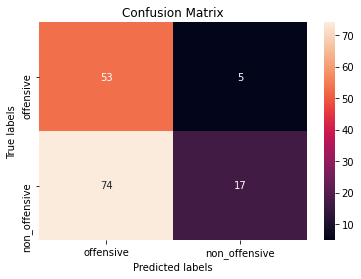

In [40]:
#confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['offensive','non_offensive']);
ax.yaxis.set_ticklabels(['offensive','non_offensive']);

In [41]:
#creating the base model iwth imagenet weights
pre_trained_image_model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [42]:
#create base model with imagenet weights
base_img = Image_model(pre_trained_image_model)
img_prediction_layer = Dense(1, activation='sigmoid')(base_img)

In [43]:
#defining image model
img_model = Model(inputs = [pre_trained_image_model.input], outputs=img_prediction_layer)

In [44]:
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

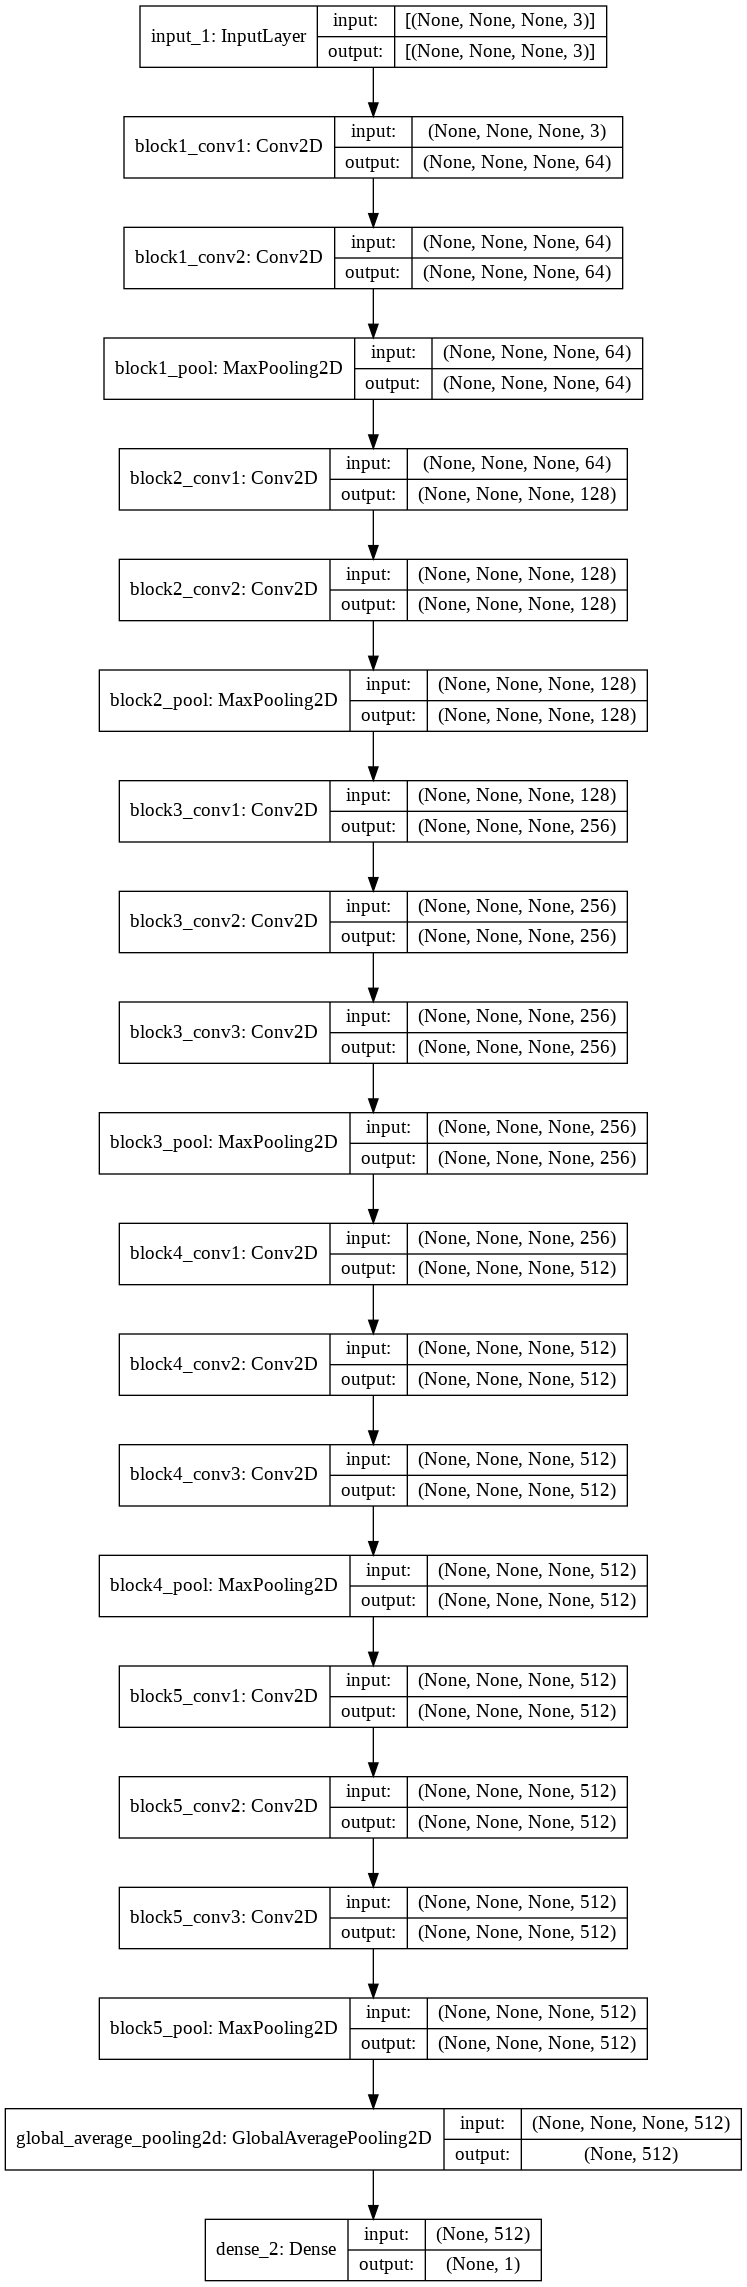

In [45]:
plot_model(img_model, to_file="/content/drive/MyDrive/Code and Program/VGG16_img_model.png", show_shapes=True, show_layer_names=True)

In [46]:
#training the image model
model2 = img_model.fit_generator(img_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_gen_val, shuffle=False, class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
2/2 [==============================] - 100s 85s/step - loss: 2.5529 - accuracy: 0.5729 - val_loss: 0.0621 - val_accuracy: 1.0000
Epoch 2/7
2/2 [==============================] - 98s 84s/step - loss: 2.3302 - accuracy: 0.6042 - val_loss: 0.0438 - val_accuracy: 1.0000
Epoch 3/7
2/2 [==============================] - 99s 84s/step - loss: 2.0640 - accuracy: 0.6250 - val_loss: 0.0422 - val_accuracy: 1.0000
Epoch 4/7
2/2 [==============================] - 98s 84s/step - loss: 1.7909 - accuracy: 0.6250 - val_loss: 0.0545 - val_accuracy: 1.0000
Epoch 5/7
2/2 [==============================] - 98s 84s/step - loss: 1.5332 - accuracy: 0.6667 - val_loss: 0.0871 - val_accuracy: 1.0000
Epoch 6/7
2/2 [==============================] - 98s 84s/step - loss: 1.3030 - accuracy: 0.6562 - val_loss: 0.1555 - val_accuracy: 1.0000
Epoch 7/7
2/2 [==============================] - 98s 84s/step - loss: 1.0986 - accuracy: 0.6562 - val_loss: 0.2785 - val_accuracy: 1.0000


In [47]:
img_model.save('VGG16_img_model.h5')

In [48]:
#predicting labels using image model
y_pred_img = (img_model.predict_generator(img_gen_test, steps = 149))
y_pred_img = np.round(list(itertools.chain(*y_pred_img)))
y_true = y_test.values
y_true

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

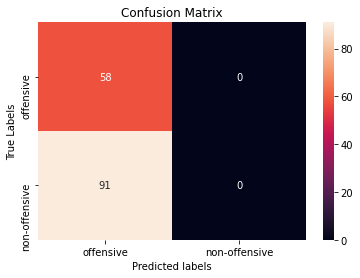

In [49]:
#Confusion matrix for image classifier
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_img, labels)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax);

ax.set_xlabel("Predicted labels");
ax.set_ylabel("True Labels");
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']);
ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [50]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

In [51]:
#concatenating the output of both the classifiers(text and image)
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1, activation='sigmoid')(con_layer)

In [52]:
#Common Model
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [53]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

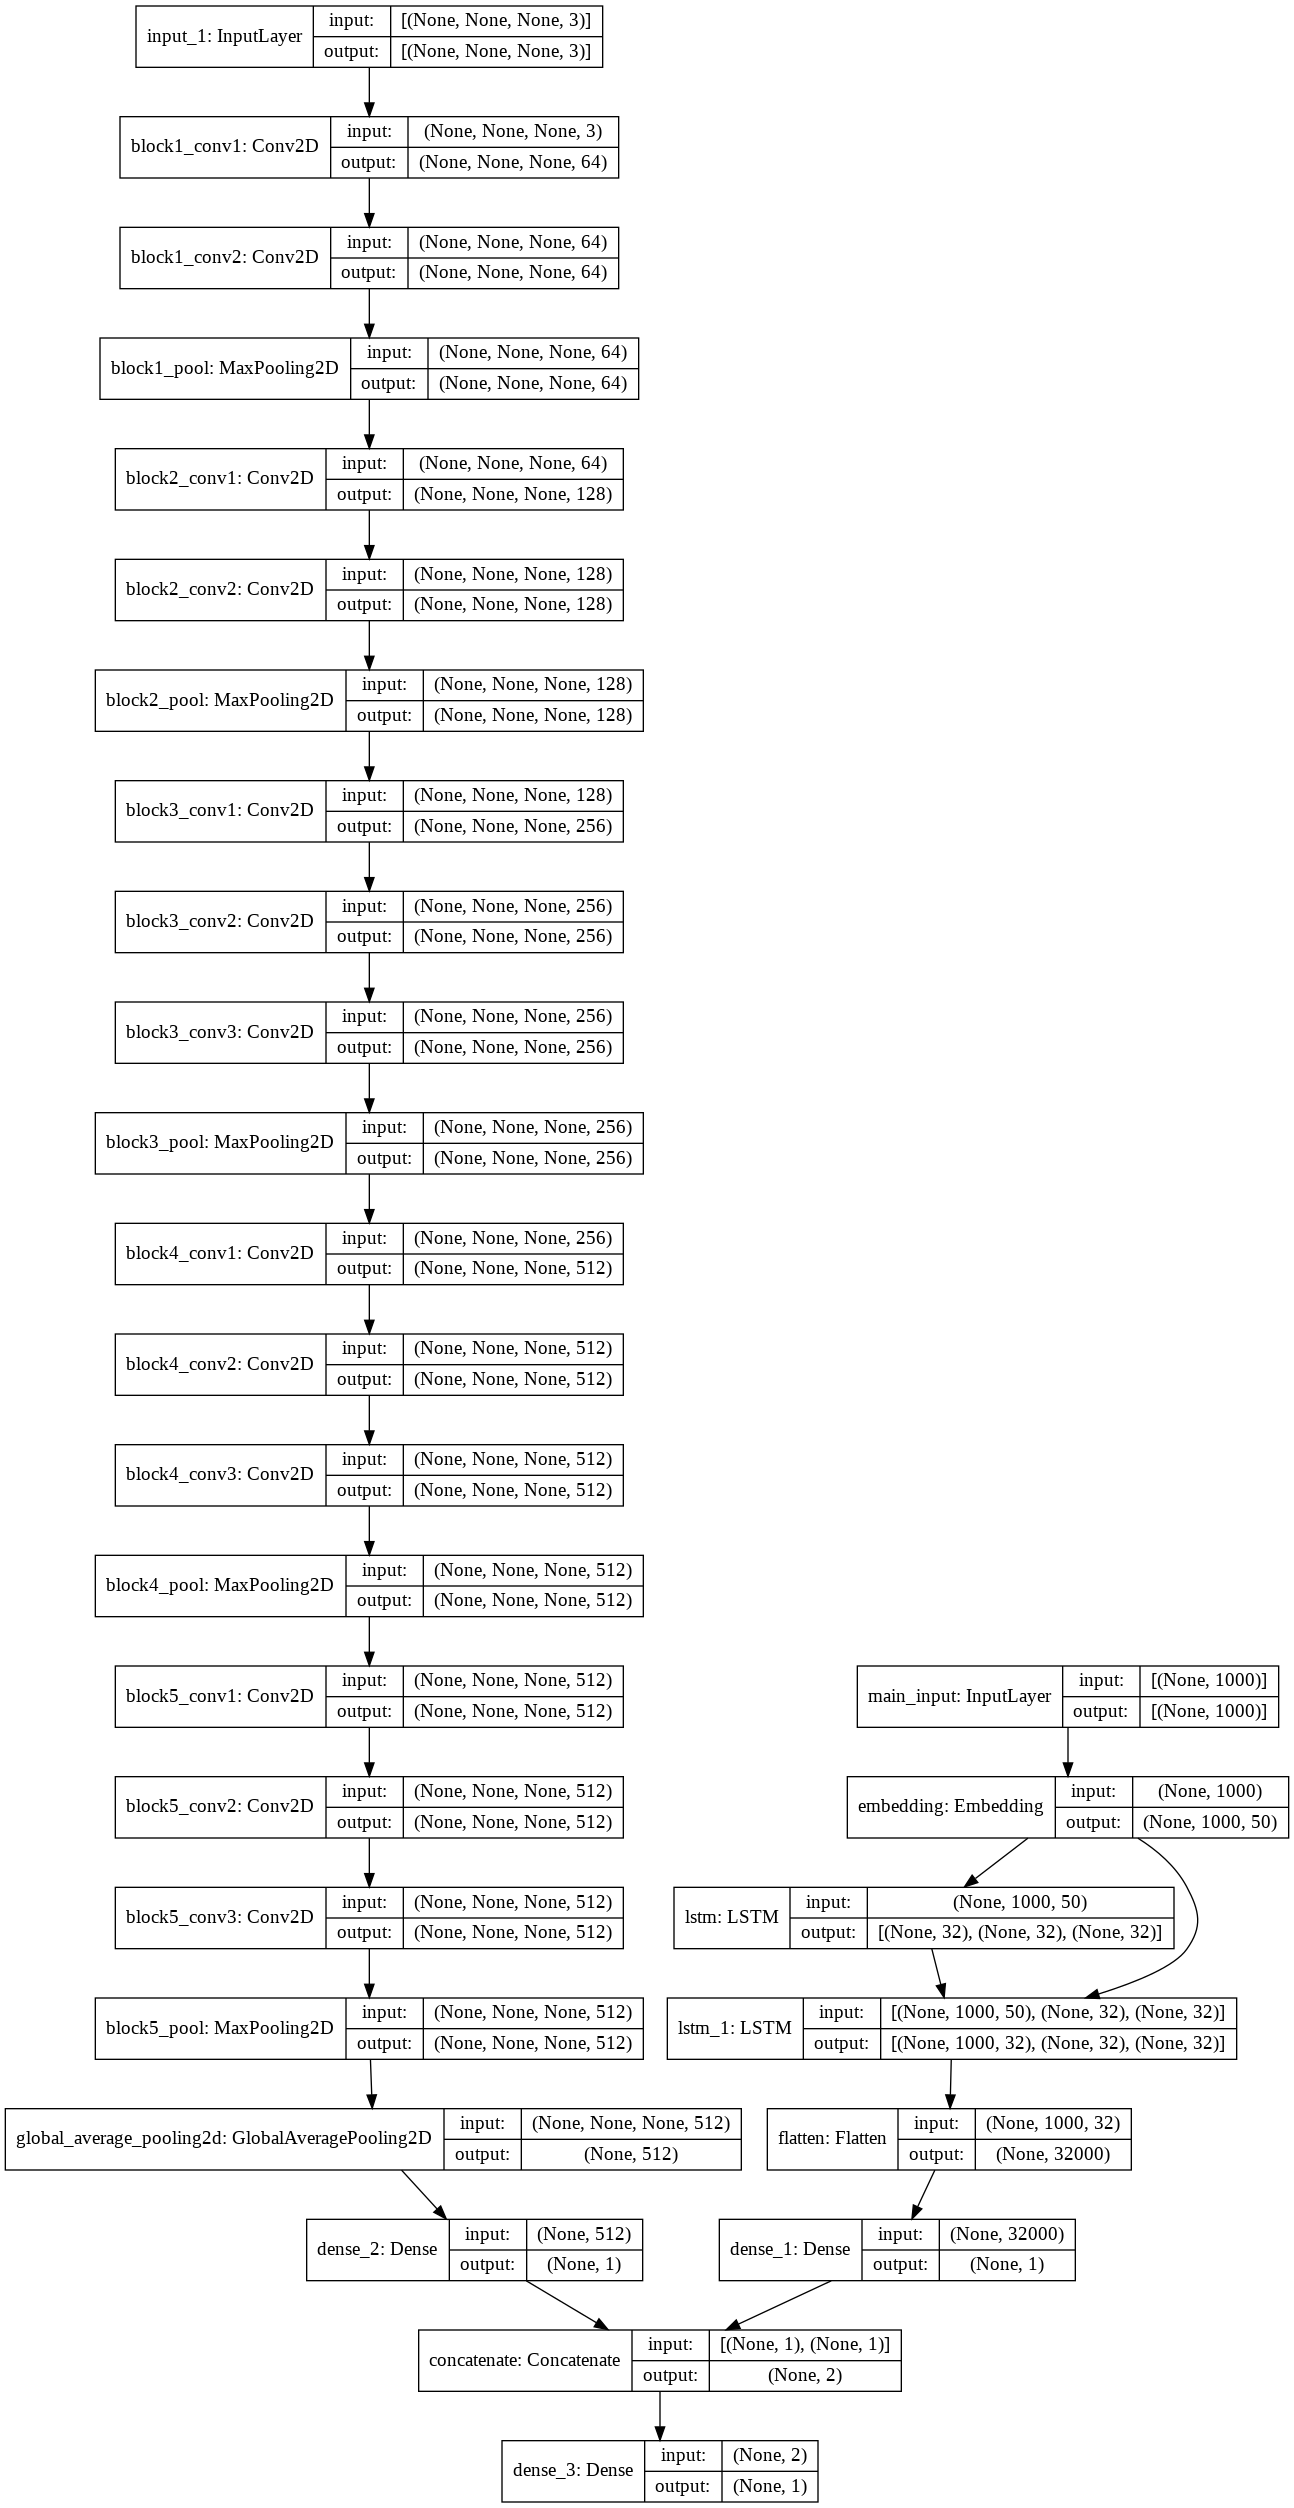

In [54]:
plot_model(com_model, to_file='/content/drive/MyDrive/Code and Program/Stack_LSTM_mul_model.png', show_shapes=True, show_layer_names=True)

In [55]:
#Training the combined model
model3 = com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
2/2 [==============================] - 116s 98s/step - loss: 0.8071 - accuracy: 0.5104 - val_loss: 0.7364 - val_accuracy: 0.4161
Epoch 2/7
2/2 [==============================] - 106s 91s/step - loss: 0.8407 - accuracy: 0.3750 - val_loss: 0.7397 - val_accuracy: 0.3691
Epoch 3/7
2/2 [==============================] - 105s 90s/step - loss: 0.8161 - accuracy: 0.4479 - val_loss: 0.7148 - val_accuracy: 0.4362
Epoch 4/7
2/2 [==============================] - 105s 90s/step - loss: 0.8089 - accuracy: 0.3958 - val_loss: 0.7193 - val_accuracy: 0.4430
Epoch 5/7
2/2 [==============================] - 105s 90s/step - loss: 0.8032 - accuracy: 0.4062 - val_loss: 0.7288 - val_accuracy: 0.4027
Epoch 6/7
2/2 [==============================] - 105s 90s/step - loss: 0.8155 - accuracy: 0.3854 - val_loss: 0.7225 - val_accuracy: 0.4094
Epoch 7/7
2/2 [==============================] - 105s 89s/step - loss: 0.8017 - accuracy: 0.3854 - val_loss: 0.7305 - val_accuracy: 0.4228


In [56]:
com_model.save('Stack_LSTM_VGG_mul_model.h5')

In [57]:
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


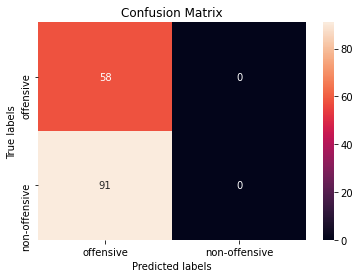

In [58]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

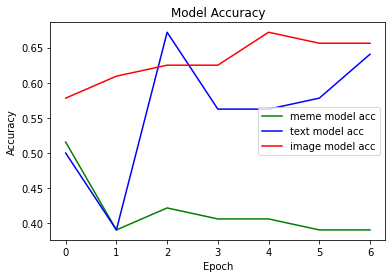

In [59]:
# Plotting training accuaracy 
plt.plot(model3.history['accuracy'],'g')
plt.plot(model1.history['accuracy'],'b')
plt.plot(model2.history['accuracy'],'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.gca().legend(('meme model acc', 'text model acc', 'image model acc'))
plt.show()

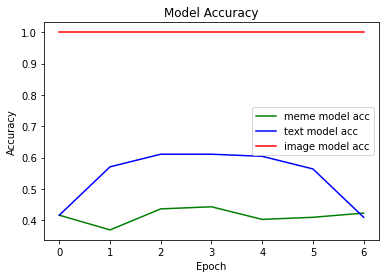

In [60]:
#plotting validation accuracy
plt.plot(model3.history['val_accuracy'],'g')
plt.plot(model1.history['val_accuracy'],'b')
plt.plot(model2.history['val_accuracy'],'r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.gca().legend(('meme model acc', 'text model acc', 'image model acc'))
plt.show()

In [61]:
#Evaluating combined model by calculating loss and accuracy
com_model.evaluate_generator(img_txt_gen_test, steps=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.7952982783317566, 0.20000000298023224]

In [62]:
#text model loss and accuracy
txt_model.evaluate_generator(txt_gen_test, steps=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.6762531995773315, 0.6000000238418579]

In [63]:
#Image model loss and accuracy
img_model.evaluate(img_gen_test, steps=5)

5/5 [==============================] - 3s 462ms/step - loss: 0.5538 - accuracy: 1.0000


[0.5538042187690735, 1.0]

In [64]:
from sklearn.metrics import precision_recall_fscore_support

In [65]:
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average=None)


(array([0.77272727, 0.41732283]),
 array([0.18681319, 0.9137931 ]),
 array([0.30088496, 0.57297297]),
 array([91, 58]))

In [66]:
precision_recall_fscore_support(y_true, y_pred_img, beta=1.0, labels=None, pos_label=1, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58]))

In [67]:
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58]))